In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import torch
import matplotlib.pyplot as plt
import pandas as pd
from bayes_traj.pyro_helper import *

torch.set_default_dtype(torch.double)

# Read toy data and plot

In [3]:
df = pd.read_csv('2d_gaussian_3_visits_std-0.05.csv')
preds = ['intercept', 'age']
targets = ['y1']

Color-code data based on ground-truth trajectory assignment ('traj_gt')

Text(0, 0.5, 'y1')

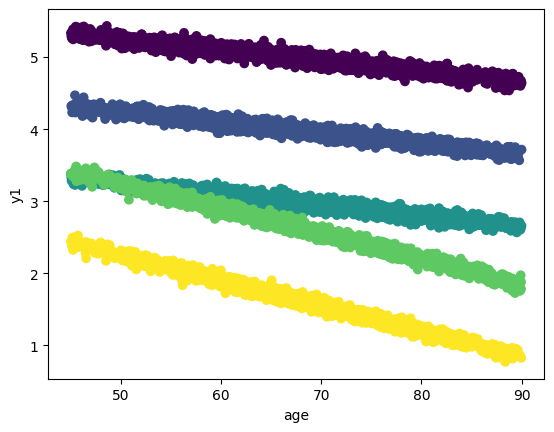

In [4]:
plt.scatter(df['age'], df['y1'], c=df['traj_gt'])
plt.xlabel('age')
plt.ylabel('y1')

# Fit to data

In [63]:
!bayes_traj_main --in_csv 2d_gaussian_3_visits_std-0.05.csv --targets y1 --groupby id --prior 2d_gaussians_3_visits_std-0.05_prior.p --verbose --iters 4000 --repeats 1 --use_pyro -k 5 --out_model foo_pyro.pt

Reading prior...
Reading data...
Fitting...
step    0 loss = 191.794
step  100 loss = 563.174
step  200 loss = 257.734
step  300 loss = 388.910
step  400 loss = 536.098
step  500 loss = 205.935
step  600 loss = 99.568
step  700 loss = 187.783
step  800 loss = 78.015
step  900 loss = 240.659
step 1000 loss = 77.040
step 1100 loss = 165.019
step 1200 loss = 81.157
step 1300 loss = 41.041
step 1400 loss = 61.568
step 1500 loss = 102.537
step 1600 loss = 51.762
step 1700 loss = 32.748
step 1800 loss = 61.869
step 1900 loss = 35.822
step 2000 loss = 14.158
step 2100 loss = 40.212
step 2200 loss = 20.955
step 2300 loss = 37.337
step 2400 loss = 13.360
step 2500 loss = 19.351
step 2600 loss = 4.561
step 2700 loss = 10.921
step 2800 loss = 14.941
step 2900 loss = 11.987
step 3000 loss = 3.171
step 3100 loss = 5.398
step 3200 loss = 4.992
step 3300 loss = 7.210
step 3400 loss = 2.287
step 3500 loss = 8.165
step 3600 loss = 3.547
step 3700 loss = 2.938
step 3800 loss = 2.384
step 3900 loss = 1.2

# Inspect fit

In [5]:
model = torch.load('foo_pyro.pt')

In [6]:
model.alpha0

tensor([100., 100., 100., 100., 100.])

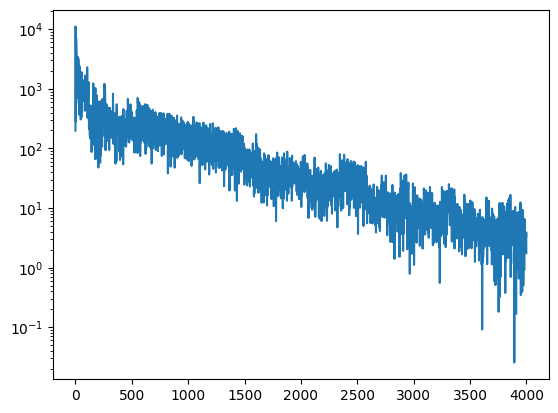

In [7]:
plt.plot(model.losses)
plt.yscale('log')

In [8]:
data = get_restructured_data(df, preds, targets, 'id')
X = data["X"]
X_mask = data["X_mask"]
Y_real = data["Y_real"]
Y_real_mask = data["Y_real_mask"]

           X: torch.Size([3, 3000, 2])
      X_mask: torch.Size([3, 3000])
      Y_real: torch.Size([3, 3000, 1])
 Y_real_mask: torch.Size([3, 3000])
      Y_bool: n/a
 Y_bool_mask: n/a


In [68]:
probs = model.classify(X, Y_real=Y_real, Y_real_mask=Y_real_mask)

In [69]:
print(probs)

tensor([[0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        [0., 0., 0., 0., 1.],
        ...,
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.],
        [1., 0., 0., 0., 0.]])


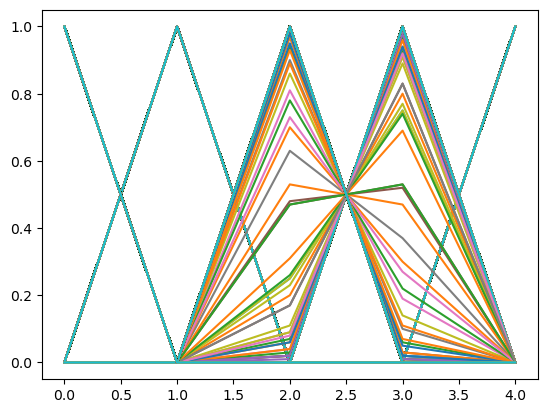

In [70]:
plt.plot(probs.T);

Overlap trajectories with data to inspect fit:

In [58]:
np.sum(probs.numpy(),0)

array([600. , 600. , 600. , 605.4, 594.6])

In [38]:
np.argmax(probs.numpy(), axis=1)

array([1, 1, 1, ..., 0, 0, 0])

In [39]:
df['traj_gt']

0       1
1       1
2       1
3       1
4       1
       ..
8995    5
8996    5
8997    5
8998    5
8999    5
Name: traj_gt, Length: 9000, dtype: int64

In [71]:
model.estimate_params()

{'W_mu': tensor([[[ 4.0178, -0.0350]],
 
         [[ 4.9917, -0.0141]],
 
         [[ 5.0582, -0.0368]],
 
         [[ 4.0903, -0.0156]],
 
         [[ 5.8367, -0.0142]]]),
 'W_var': tensor([[[4.4792e-05, 9.5838e-09]],
 
         [[3.4558e-06, 6.2927e-09]],
 
         [[6.4778e-05, 1.0495e-08]],
 
         [[1.1055e-04, 1.3657e-08]],
 
         [[1.7073e-04, 2.0021e-08]]]),
 'lambda_mu': tensor([[399.7644],
         [399.7699],
         [400.0261],
         [399.7907],
         [399.8267]]),
 'lambda_var': tensor([[0.0002],
         [0.0004],
         [0.0002],
         [0.0003],
         [0.0036]])}

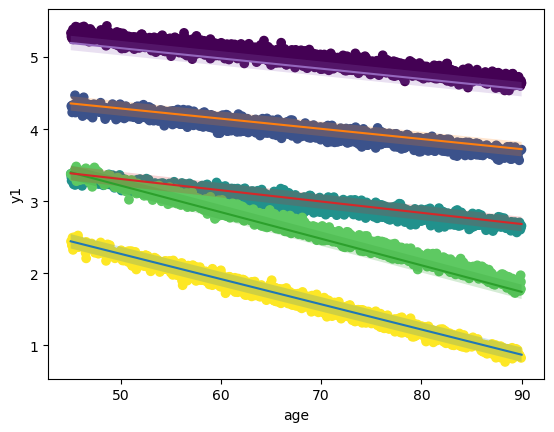

In [72]:
plt.close('all')


plt.scatter(df['age'], df['y1'], c=df['traj_gt'])
#plt.scatter(df['age'], df['y1'], c=np.argmax(probs.numpy(), axis=1))
plt.xlabel('age')
plt.ylabel('y1')

#self.guide.median()

#self.guide() # Dictionary (Draws a sample)

K = 5
X = torch.ones([100, 2])
X[:, 1] = torch.linspace(45, 90, 100)
for kk in range(K):
    #w = model.params['params']['AutoNormal.locs.W_'][kk, 0].data.numpy()
    #(model.estimate_params()['lambda_mu']).rsqrt().numpy()
    #lambda_ = model.params['params']['AutoNormal.locs.lambda_'][kk].data
    stddev = (model.estimate_params()['lambda_mu']).rsqrt().numpy()[kk]
    w = (model.estimate_params()['W_mu']).numpy()[kk,0]
    
    y1_tmp = np.dot(X.numpy(), w.T)
    plt.plot(X[:, 1], y1_tmp)
    lb = y1_tmp - 2*stddev
    ub = y1_tmp + 2*stddev
    plt.fill_between(X[:, 1], lb, ub, alpha=0.2)
plt.show()

In [21]:
1/np.sqrt(lambda_.item())


0.4087097075189758

In [22]:
print(model.params['params'])

{'AutoNormal.locs.class_probs': Parameter containing:
tensor([ 0.1484, -0.0226,  0.0086, -0.2148], requires_grad=True), 'AutoNormal.scales.class_probs': Parameter containing:
tensor([-4.5952, -4.5952, -4.6052, -4.5952], requires_grad=True), 'AutoNormal.locs.W_': Parameter containing:
tensor([[[ 5.2234, -0.0233]],

        [[ 5.4480, -0.0324]],

        [[ 4.3478, -0.0417]],

        [[ 6.4087, -0.0357]],

        [[ 6.2381, -0.0309]]], requires_grad=True), 'AutoNormal.scales.W_': Parameter containing:
tensor([[[-4.5952, -4.5952]],

        [[-4.5952, -4.5952]],

        [[-4.5952, -4.5952]],

        [[-4.5952, -4.6052]],

        [[-4.6052, -4.5952]]], requires_grad=True), 'AutoNormal.locs.lambda_': Parameter containing:
tensor([[5.9865],
        [5.9965],
        [5.9864],
        [5.9965],
        [5.9865]], requires_grad=True), 'AutoNormal.scales.lambda_': Parameter containing:
tensor([[-4.6052],
        [-4.6052],
        [-4.6052],
        [-4.6052],
        [-4.6052]], requires_